### Websites to Scrape:
1. https://app.powerbi.com/view?r=eyJrIjoiZGNhZGIwM2QtYTM2NC00ZjRiLTliNmMtZjdiMGQ2ZDRjYjg2IiwidCI6IjM4MmZiOGIwLTRkYzMtNDEwNy04MGJkLTM1OTViMjQzMmZhZSIsImMiOjZ9
2. 

In [233]:
from requests import get
import requests
from bs4 import BeautifulSoup
from time import sleep
import re
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np
import datetime
import pandas as pd
import us
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

### Cities

In [26]:
r = requests.get("https://ballotpedia.org/Changes_to_policing_policy_in_the_states_and_100_largest_cities,_2020#Local_responses_in_100_largest_cities")

In [84]:
html = r.content
soup = BeautifulSoup(html, 'html5lib')

In [98]:
cities = []
state = []
date = []
text = []

city_policies = soup.find_all('span', class_='mw-headline')[72:151]
for i in range(len(city_policies)):
    # city
    try:
        city = city_policies[i].a['title']
        cities.append(city)
    except TypeError:
        pass

In [104]:
cities

In [118]:
# from selenium import webdriver
# import pandas as pd


# driver = webdriver.Chrome('C:/chromedriver_win32/chromedriver.exe')
# driver.get("http://useofforceproject.org/#review")

# html = driver.page_source

# tables = pd.read_html(html)
# data = tables[1]

# driver.close()

In [120]:
# html

In [122]:
city_policies[0].a['title']

'Atlanta, Georgia'

In [2]:
# city_policies

In [74]:
# soup.find_all('td')[25:]

In [76]:
# soup.find_all('p')[25:]

In [3]:
# soup.find_all('span', class_='mw-headline')[72:151]

In [4]:
# soup

### States:
- Data scraped from: https://www.ncsl.org/research/civil-and-criminal-justice/legislative-responses-for-policing.aspx

In [401]:
%time

df_pol = []

for year, div_id in {2020: "dnn_ctr93953_StateNetDB_linkList", 2021: "dnn_ctr92166_StateNetDB_linkList"}.items():
    # read html page
    soup = BeautifulSoup(open(fr"C:/Users/Leonardo/OneDrive/Documents/TU_Delft/CodingProjects/PoliceBrutality/data/raw/NCLS/{year}_policies.html"), "html.parser")
    # clean html and convert policies to list of strings
    policies = soup.find_all('div', id = div_id)[0].text.split('\n')
    policies_str = list(filter(None,[el.replace('  ','') for el in list(filter(None, policies))]))
    policies_str_cl = [el for el in policies_str if "Text Lookup" not in el]
    print("There were", len([policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']), f"state policies related to policing in {year}.")
    # extract all info of interest
    policy_id = [policies_str_cl[i-3] for i, x in enumerate(policies_str_cl) if x == 'Status:']
    state = [el[:2] for el in policy_id]
    year = [el for el in policies_str_cl if el.startswith("2021") or el.startswith("2020")]
    status = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']
    DOLA = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Date of Last Action:*\xa0']
    author = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Author:']
    topics = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Topics: ']
    summary = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Summary: ']
    history = [policies_str_cl[i-4] for i, x in enumerate(policies_str_cl) if x == 'Status:']

    # make dataframe
    df_data = {"policy_id": policy_id, "state": state, "year": year, "status": status, 
               "date_of_last_action": DOLA, "author": author, "topics": topics, "summary": summary, "history": history}
    df = pd.DataFrame.from_dict(df_data)
    df_pol.append(df)
    
df_policies = pd.concat(df_pol).reset_index().drop("index", axis=1)
df_policies.to_csv("../data/raw/NCLS/2020_2021_state_policies.csv")
print("In total, there were", len(df_policies), f"state policies related to policing since the murder of George Floyd on May, 25th, 2020.")

Wall time: 0 ns
There were 744 state policies related to policing in 2020.
There were 1348 state policies related to policing in 2021.
In total, there were 2092 state policies related to policing since the murder of George Floyd on May, 25th, 2020.


In [60]:
print("ADOPTION: Approval or acceptance; usually applied to amendments, committee reports or resolutions.")
print("")
print("ACT: Legislation enacted into law. A bill that has passed both houses of the legislature, been enrolled, ratified, signed by the governor or passed over the governor's office, and printed. It is a permanent measure, having the force of law until repealed.")
print("Local act: Legislation enacted into law that has limited application.")
print("Private act: Legislation enacted into law that has limited application.")
print("Public act: Legislation enacted into law that applies to the public at large.")
print("")
print("VETO: Action by the governor to disapprove a measure.")
print("")
print("from: https://www.ncsl.org/research/about-state-legislatures/glossary-of-legislative-terms.aspx")

ADOPTION: Approval or acceptance; usually applied to amendments, committee reports or resolutions.

ACT: Legislation enacted into law. A bill that has passed both houses of the legislature, been enrolled, ratified, signed by the governor or passed over the governor's office, and printed. It is a permanent measure, having the force of law until repealed.
Local act: Legislation enacted into law that has limited application.
Private act: Legislation enacted into law that has limited application.
Public act: Legislation enacted into law that applies to the public at large.

VETO: Action by the governor to disapprove a measure.

from: https://www.ncsl.org/research/about-state-legislatures/glossary-of-legislative-terms.aspx


In [402]:
df_policies = pd.read_csv("../data/raw/NCLS/2020_2021_state_policies.csv").drop("Unnamed: 0", axis=1)

In [403]:
df_policies['status_cl'] = df_policies.status.str.split('-').str[0].str.strip()
df_policies['status_cl'][df_policies['status_cl']==""] = "No Status"
df_policies['count'] = 1

unique_topics = list(set([word.strip() for sublist in list(df_policies['topics'].str.split(",").values) for word in sublist if word != "Summary: "]))
# # columns for each topic
# for topic in range(1,13):
#     df_policies[f'topic_{topic}'] = df_policies['topics'].str.split(",").str[topic]

# columns for each topic
for topic in unique_topics:
    df_policies[topic] = 0
    df_policies[topic][df_policies["topics"].str.contains(topic)] = 1
    
state_policies_stat = df_policies.groupby(["status_cl", 'state']).sum().reset_index().drop("year", axis=1)

# total number of policies per state
state_policies_stat['tot_policies'] = 0
state_policies_stat['tot_failed'] = 0
state_policies_stat['tot_success'] = 0
state_policies_stat['tot_outcome'] = 0

for state in state_policies_stat['state'].unique():
    state_policies_stat['tot_policies'][state_policies_stat['state'] == state] = state_policies_stat[state_policies_stat['state'] == state]['count'].sum()
    state_policies_stat['tot_failed'][state_policies_stat['state'] == state] = state_policies_stat[(state_policies_stat['state'] == state)&(state_policies_stat['status_cl'].isin(['Vetoed', 'Failed']))]['count'].sum()
    state_policies_stat['tot_success'][state_policies_stat['state'] == state] = state_policies_stat[(state_policies_stat['state'] == state)&(state_policies_stat['status_cl'].isin(['Enacted', 'Adopted']))]['count'].sum()
    state_policies_stat['tot_outcome'][state_policies_stat['state'] == state] = state_policies_stat[(state_policies_stat['state'] == state)&(state_policies_stat['status_cl'].isin(['Vetoed', 'Failed', 'Enacted', 'Adopted']))]['count'].sum()


C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCop

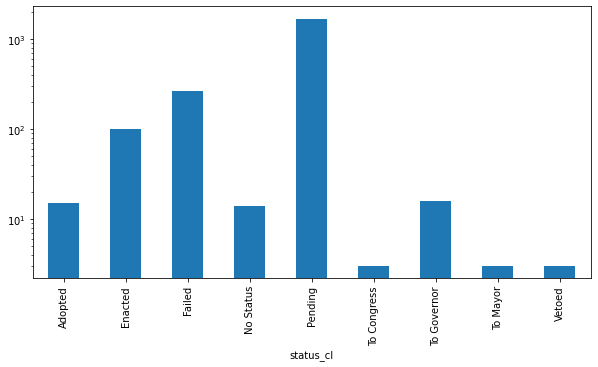

In [406]:
fig, ax = plt.subplots(figsize=(10,5)) ##[counties_tp['tweet_count']<100]
df_policies.groupby("status_cl").sum()['count'].plot(kind="bar")
ax.set_yscale('log')

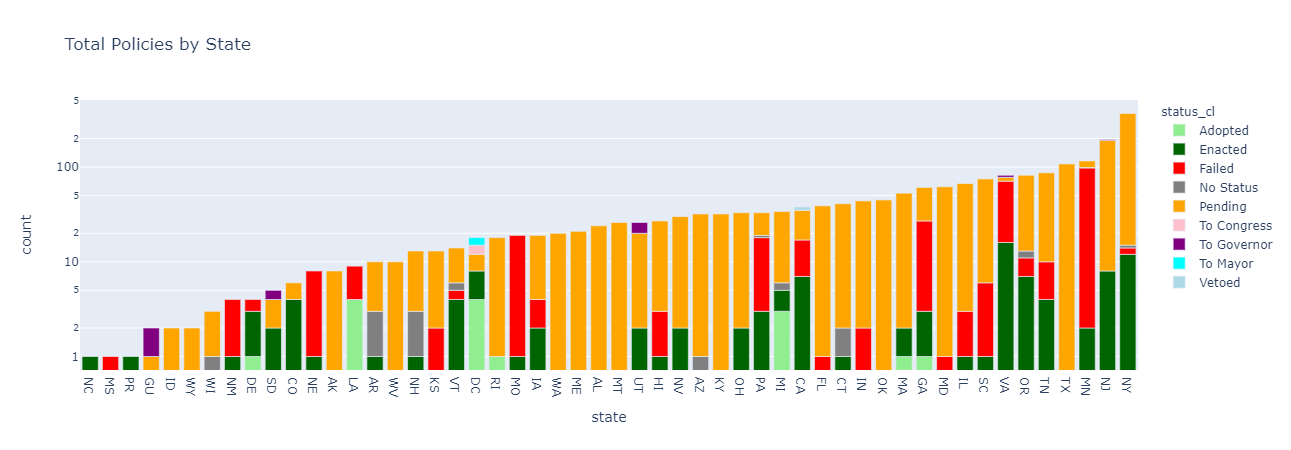

In [230]:
import plotly.express as px
fig = px.bar(state_policies_stat, x="state", y="count", color="status_cl", title="Total Policies by State", log_y=True, 
             color_discrete_sequence = ['lightgreen', 'darkgreen', 'red', "grey", "orange", "pink", "purple", "cyan", "lightblue"])
fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray':state_policies_stat.sort_values(["tot_policies"])['state'].values})
fig.show()

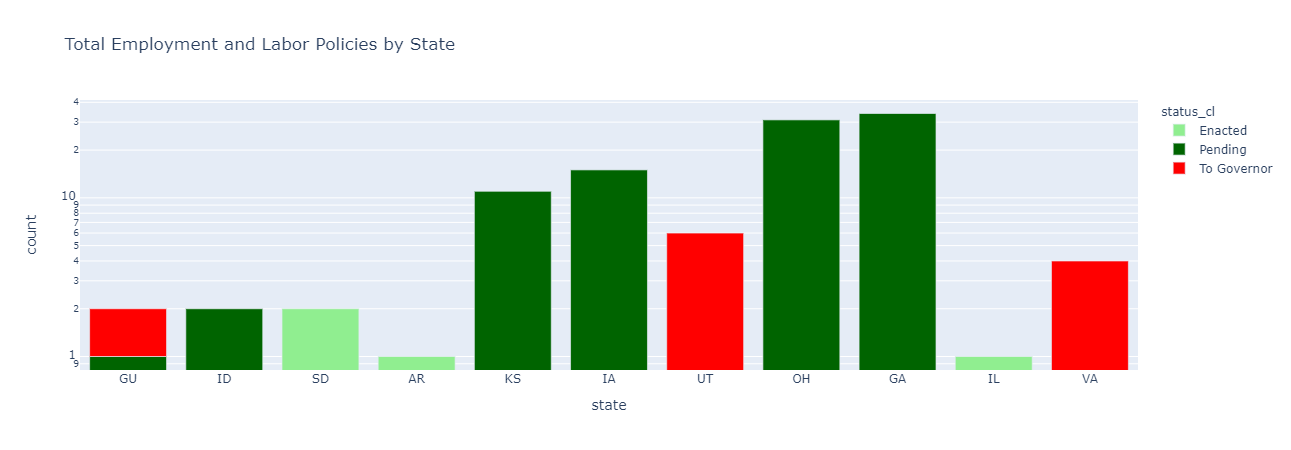

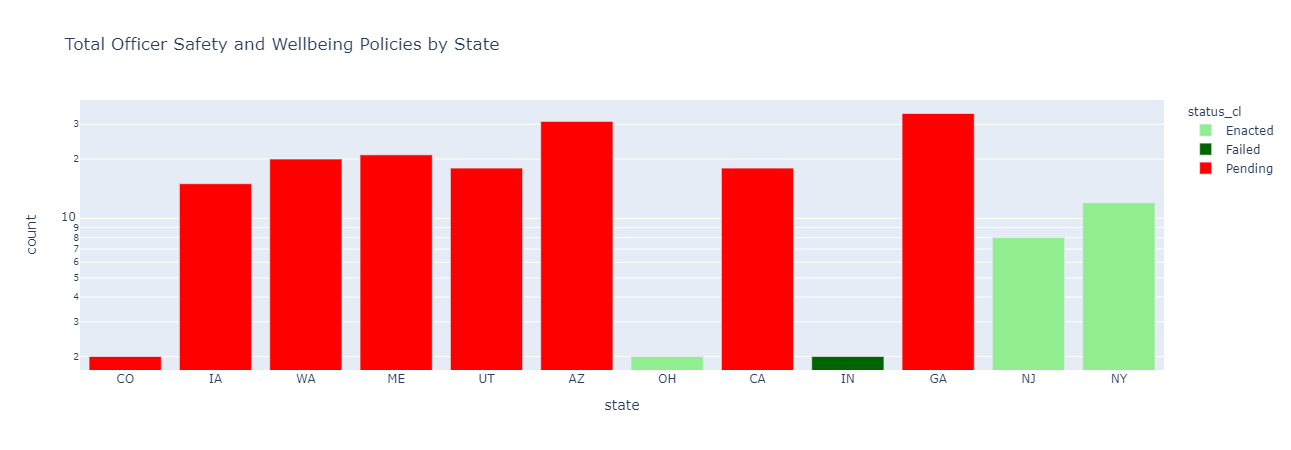

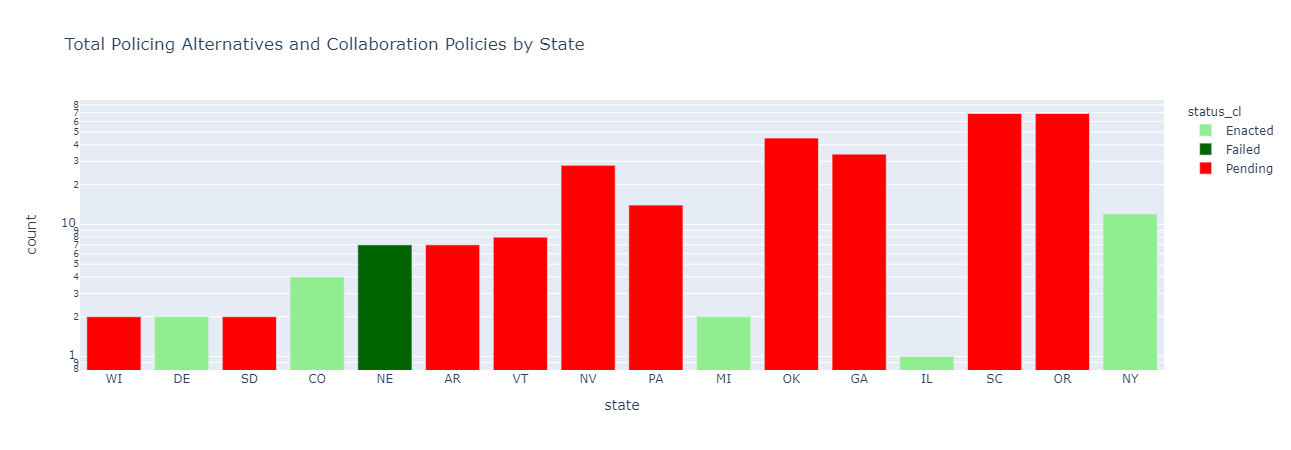

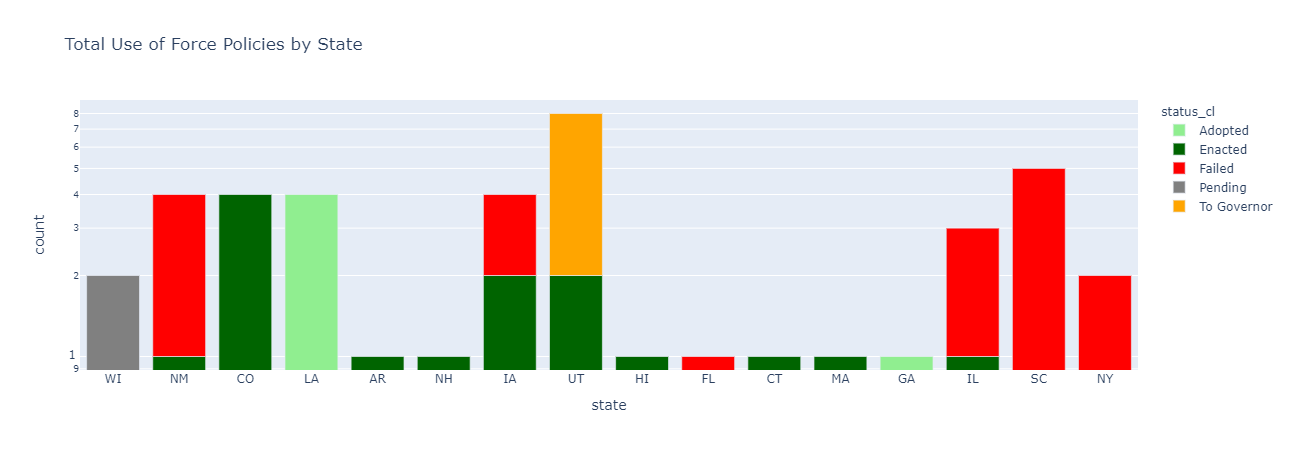

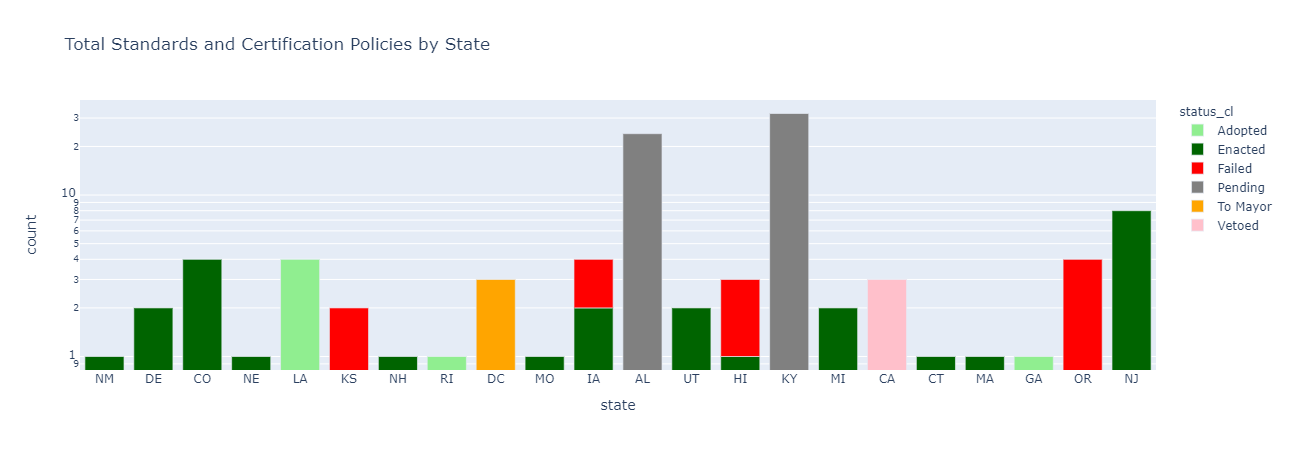

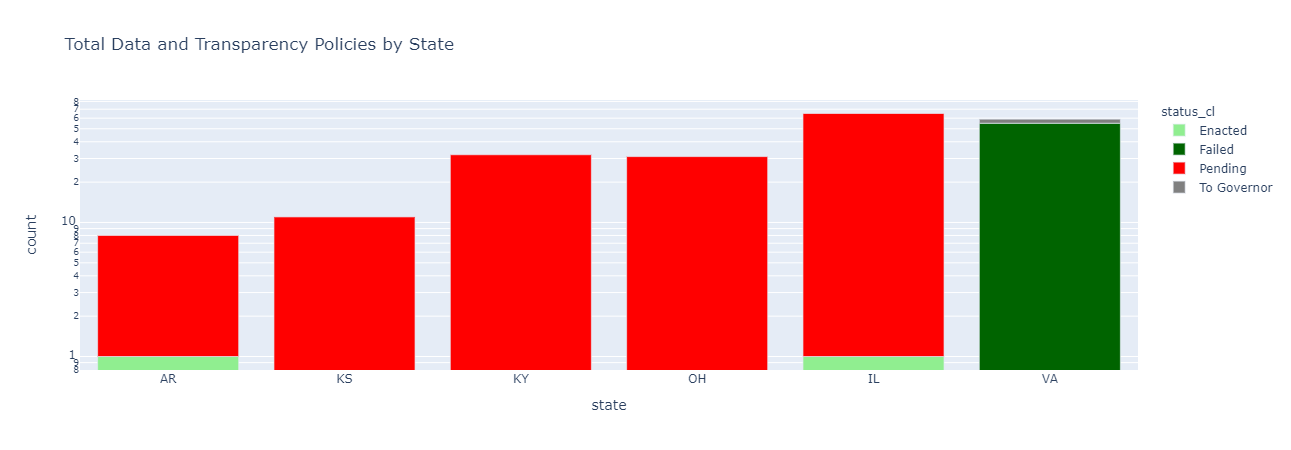

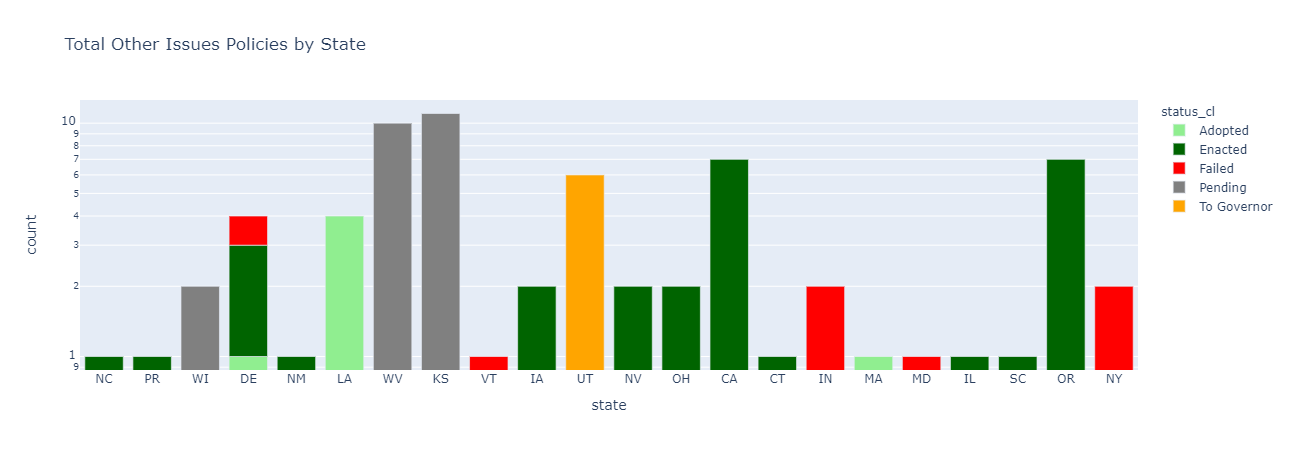

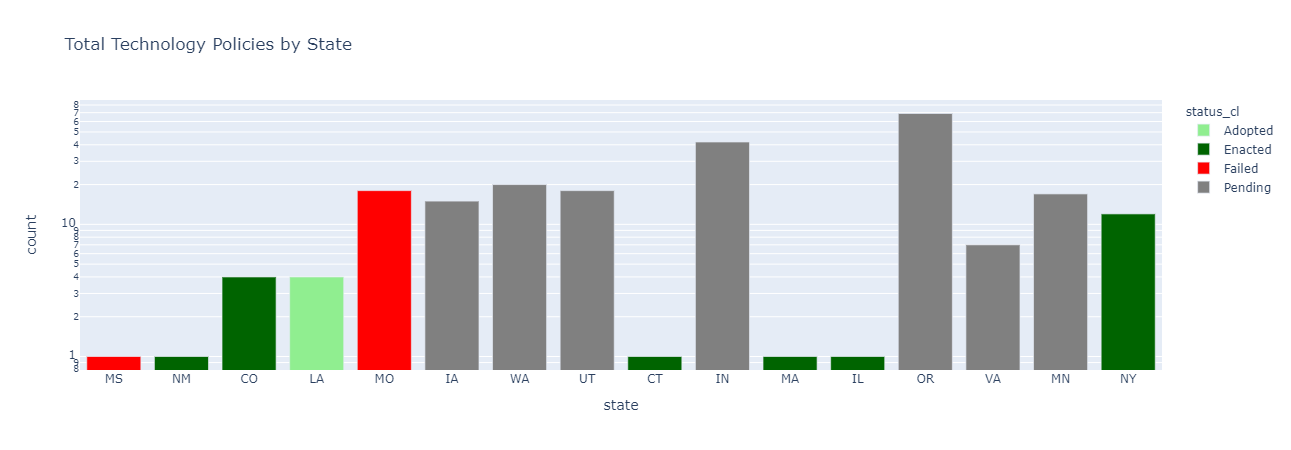

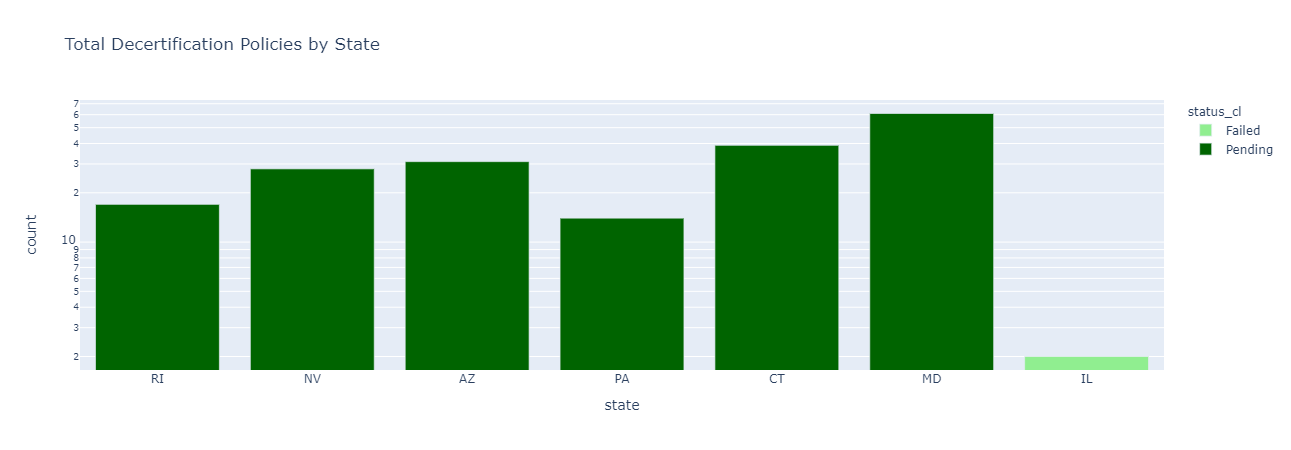

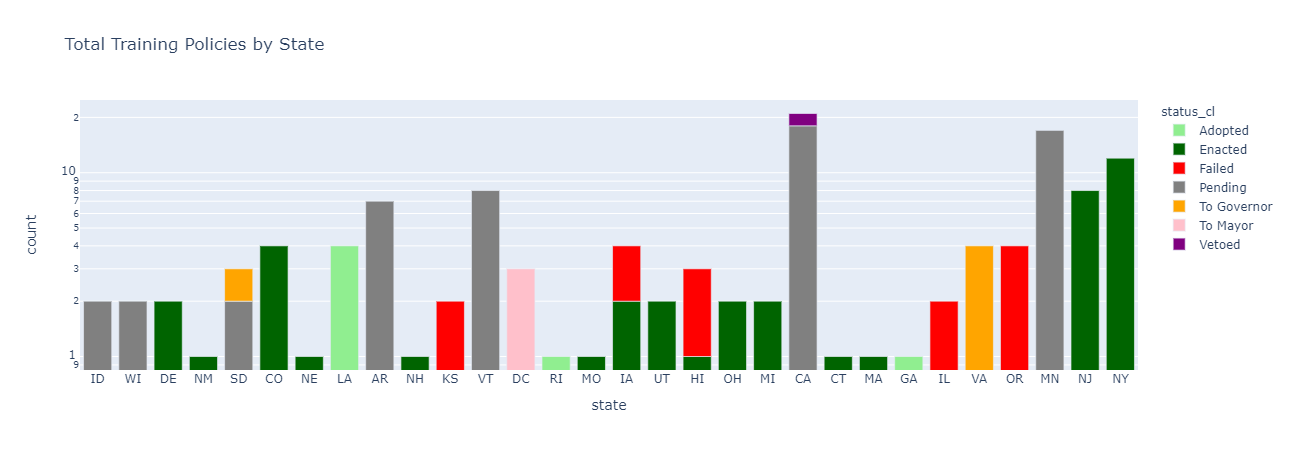

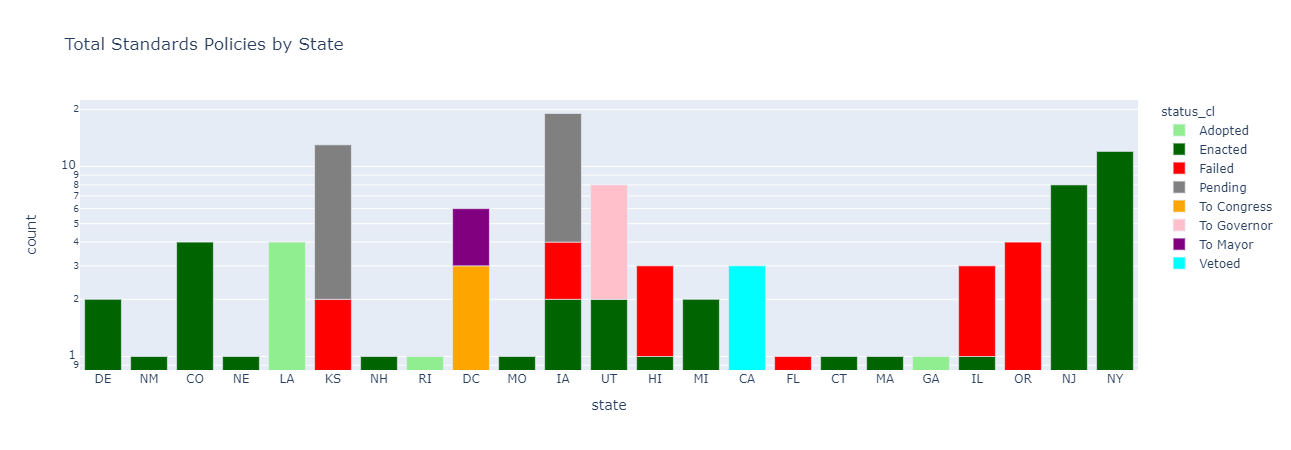

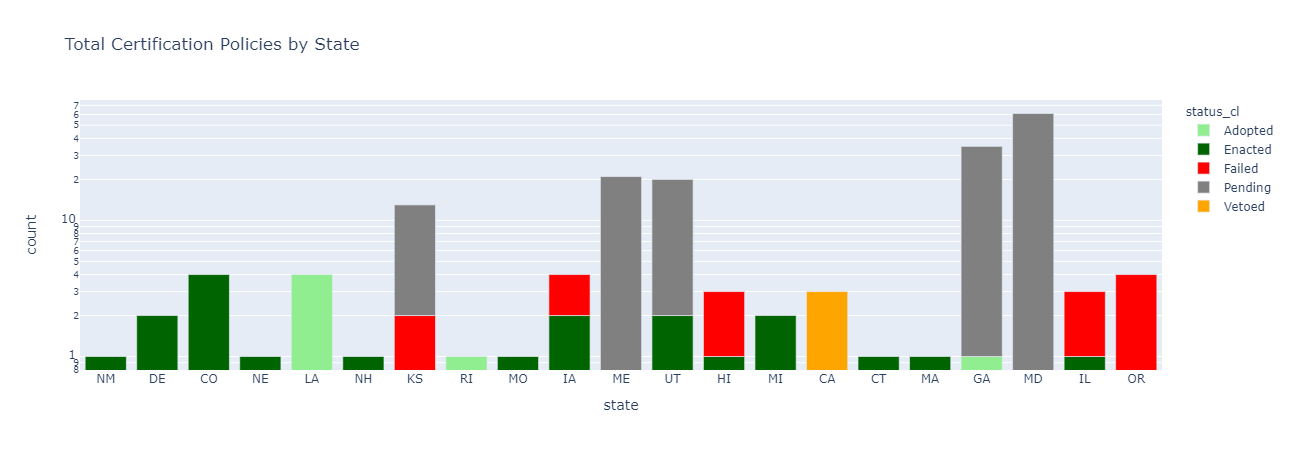

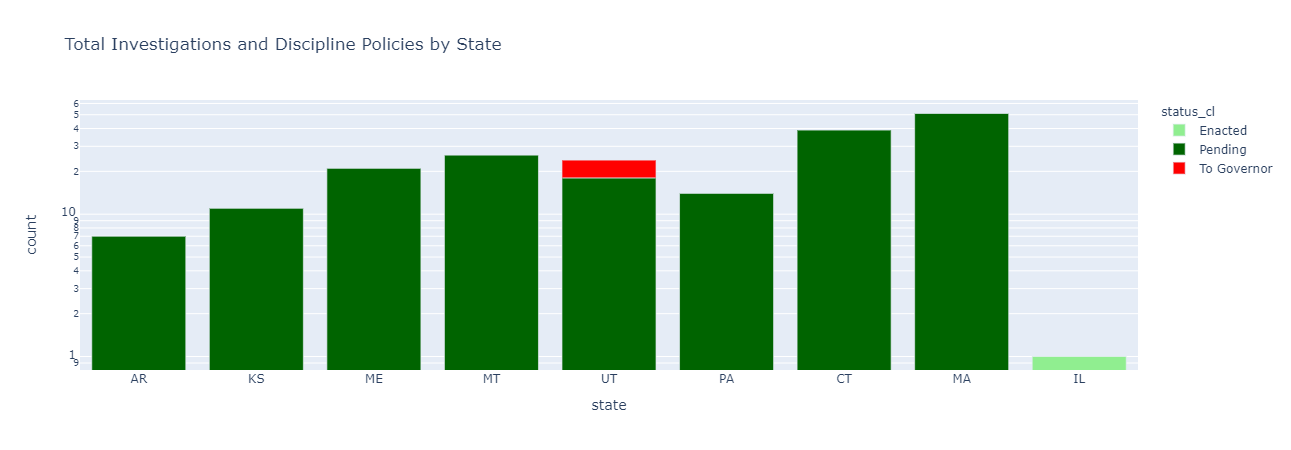

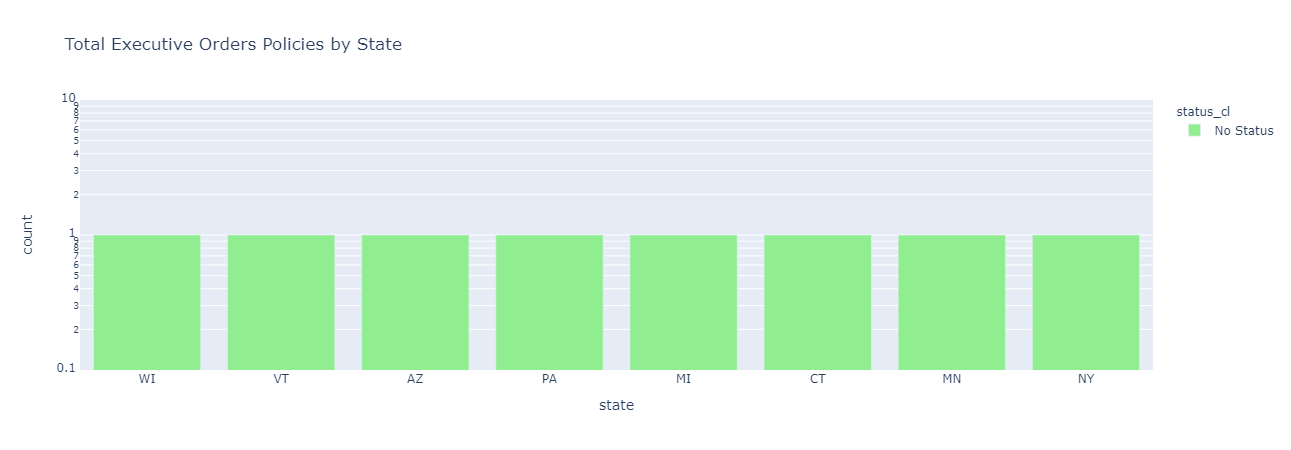

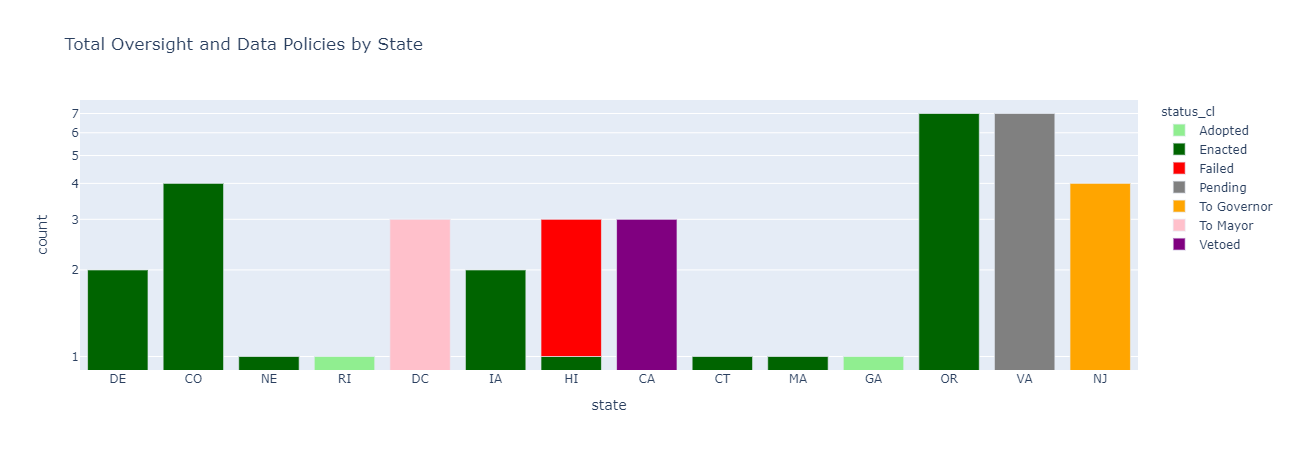

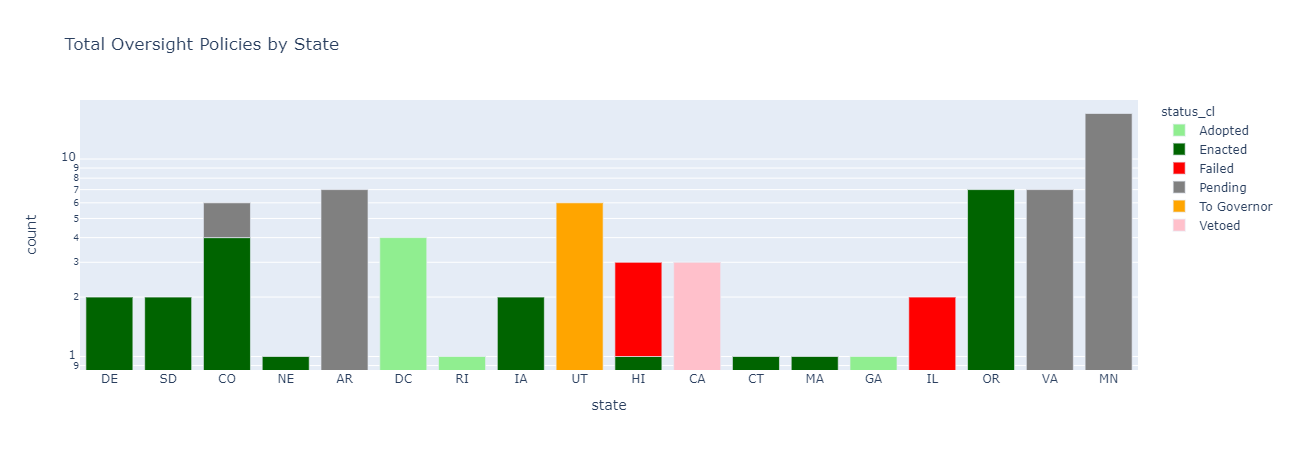

In [231]:
for topic in unique_topics:
    fig = px.bar(state_policies_stat[state_policies_stat[topic]==1], x="state", y="count", color="status_cl", title=f"Total {topic} Policies by State", log_y=True, 
                 color_discrete_sequence = ['lightgreen', 'darkgreen', 'red', "grey", "orange", "pink", "purple", "cyan", "lightblue"])
    fig.update_layout(xaxis={'categoryorder':'array', 'categoryarray': state_policies_stat[state_policies_stat[topic]==1].sort_values(["tot_policies"])['state'].values})
    fig.show()

In [327]:
tweets_geo = gpd.read_file("../data/raw/processed/tweets_us_geo.geojson")
state_abbrv = gpd.read_file("../data/raw/us_admin/us_abbrv.csv") #https://worldpopulationreview.com/states/state-abbreviations
state_pop = gpd.read_file("../data/raw/us_admin/nst-est2019-alldata.csv") #https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-total.html
state_pop['POPESTIMATE2019'] = pd.to_numeric(state_pop['POPESTIMATE2019'])
state_pop = pd.merge(state_pop, state_abbrv, left_on="NAME", right_on='State')[['Code', 'POPESTIMATE2019']]

In [413]:
tweets_geo['state'] = tweets_geo['location_cl'].str.split(",").str[-1].str.strip(" ")
tweets_geo['tweet_count'] = 1
state_tweets_stat = tweets_geo.groupby("state").sum().reset_index()[['state', 'tweet_count']]
state_tweets_stat = pd.merge(state_tweets_stat, state_pop, left_on= "state", right_on="Code").drop("Code", axis=1)
state_tweets_stat['tweets_100k'] = (pd.to_numeric(state_tweets_stat['tweet_count'])/pd.to_numeric(state_tweets_stat['POPESTIMATE2019']))*100000
state_tp_stat_all = pd.merge(state_tweets_stat, state_policies_stat.groupby("state").sum().reset_index()[['state', "count"]], on="state")
state_tp_stat_pass = pd.merge(state_tweets_stat, state_policies_stat[state_policies_stat['status_cl'].isin(['Adopted', 'Enacted'])].groupby("state").sum().reset_index()[['state', "count"]], on="state")
state_tp_stat_fail = pd.merge(state_tweets_stat, state_policies_stat[state_policies_stat['status_cl'].isin(['Failed', 'Vetoed'])].groupby("state").sum().reset_index()[['state', "count"]], on="state")
state_tp_stat_out = pd.merge(state_tweets_stat, state_policies_stat.groupby("state").mean().reset_index()[['state', "tot_policies", "tot_failed", "tot_success", "tot_outcome"]], on="state")
state_tp_stat_out['policy_success_rate'] = state_tp_stat_out['tot_success']/state_tp_stat_out['tot_outcome']
state_tp_stat_out['policy_failure_rate'] = state_tp_stat_out['tot_failed']/state_tp_stat_out['tot_outcome']
state_tp_stat_out['success_cat'] = ""
state_tp_stat_out['success_cat'][state_tp_stat_out['policy_success_rate']>=state_tp_stat_out['policy_success_rate'].mean()] = "More Successful Policies"
state_tp_stat_out['success_cat'][state_tp_stat_out['policy_success_rate']<state_tp_stat_out['policy_success_rate'].mean()] = "More Failed Policies"

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



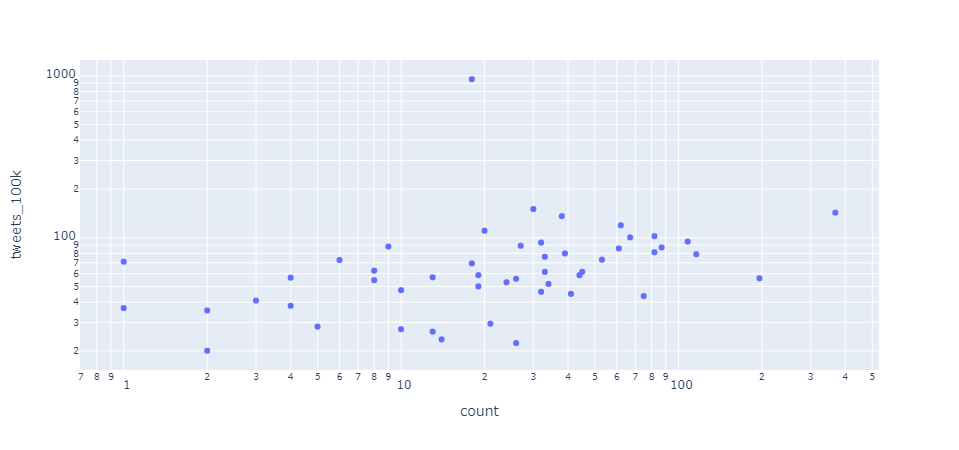

In [329]:
px.scatter(state_tp_stat_all, x = "count", y="tweets_100k", log_y=True, log_x=True, hover_data=['state', 'tweets_100k', 'count'])

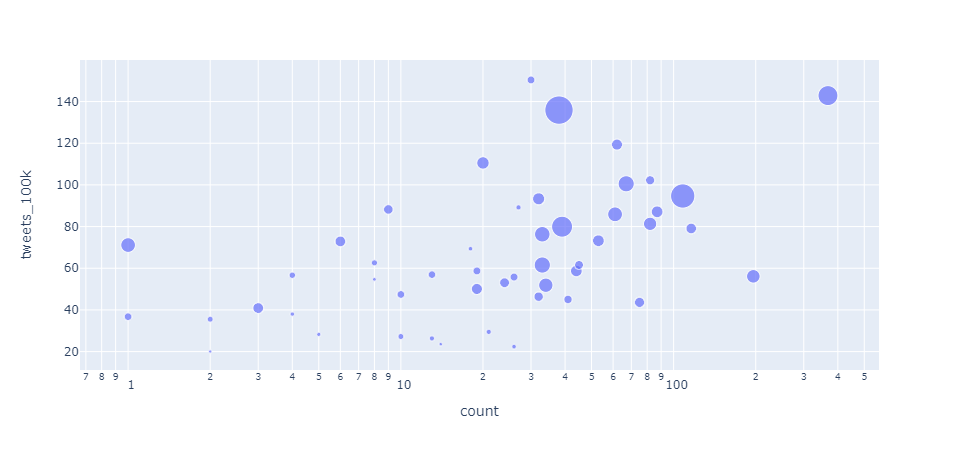

In [330]:
px.scatter(state_tp_stat_all[state_tp_stat_all['state']!="DC"], x = "count", y="tweets_100k", log_x=True, hover_data=['state', 'tweets_100k', 'count'], size = "POPESTIMATE2019")

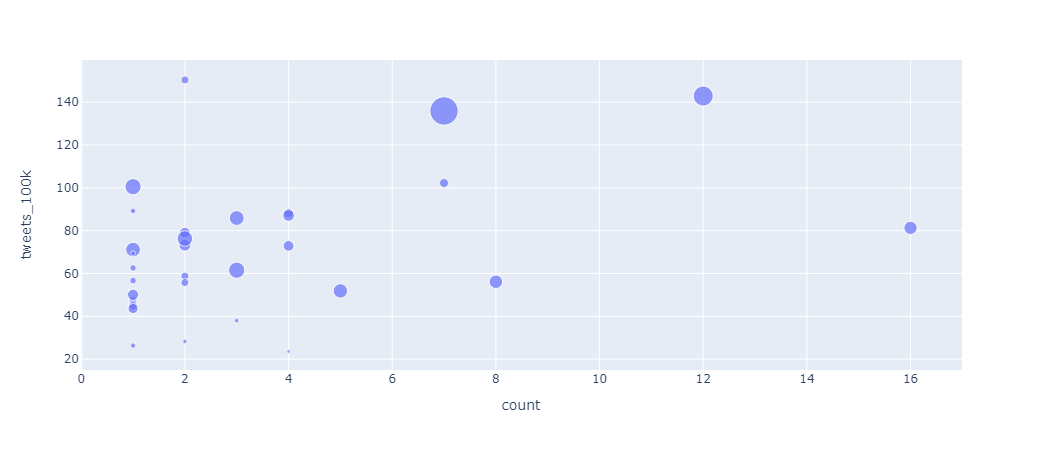

In [331]:
px.scatter(state_tp_stat_pass[state_tp_stat_pass['state']!="DC"], x = "count", y="tweets_100k", hover_data=['state', 'tweets_100k', 'count'], size = "POPESTIMATE2019")

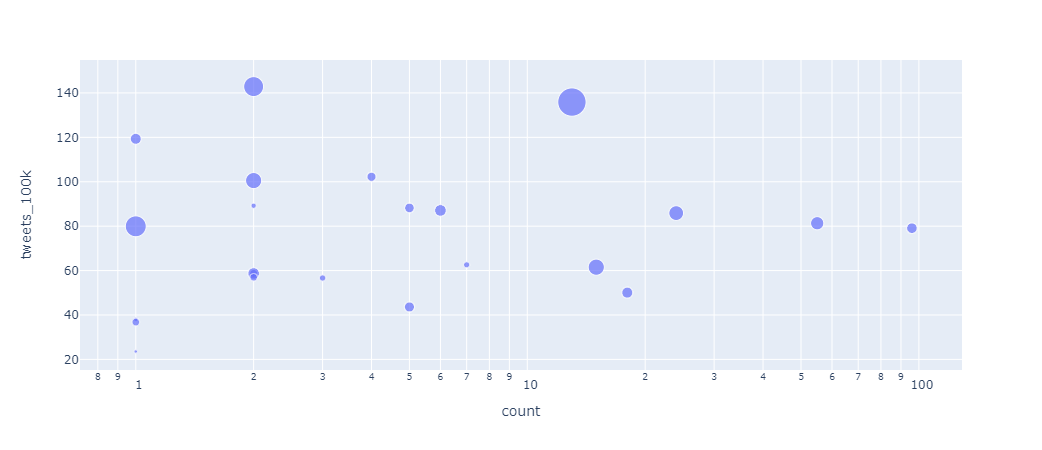

In [334]:
px.scatter(state_tp_stat_fail, x = "count", y="tweets_100k", hover_data=['state', 'tweets_100k', 'count'], size = "POPESTIMATE2019", log_x=True)

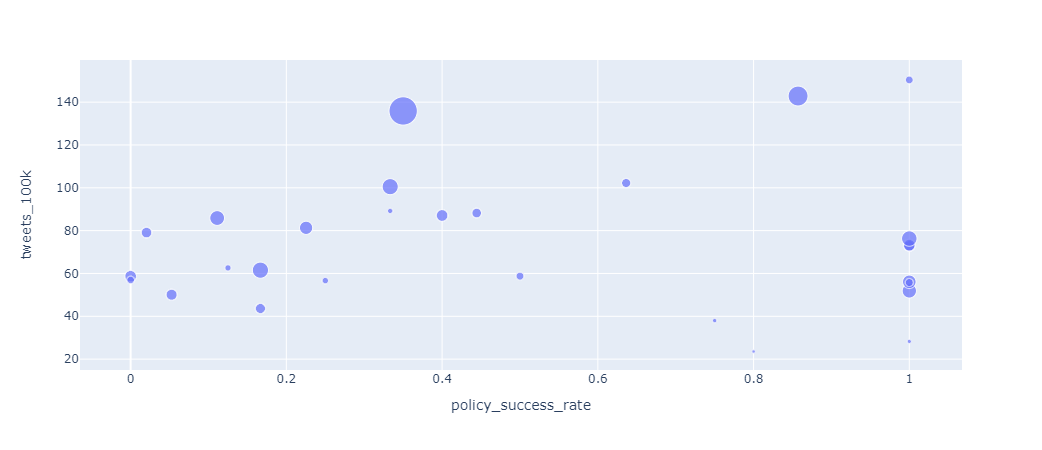

In [396]:
px.scatter(state_tp_stat_out[(state_tp_stat_out['state']!="DC")&(state_tp_stat_out['tot_outcome']>1)], x = "policy_success_rate", y="tweets_100k", hover_data=['state', 'tweets_100k', 'policy_success_rate'], size = "POPESTIMATE2019")

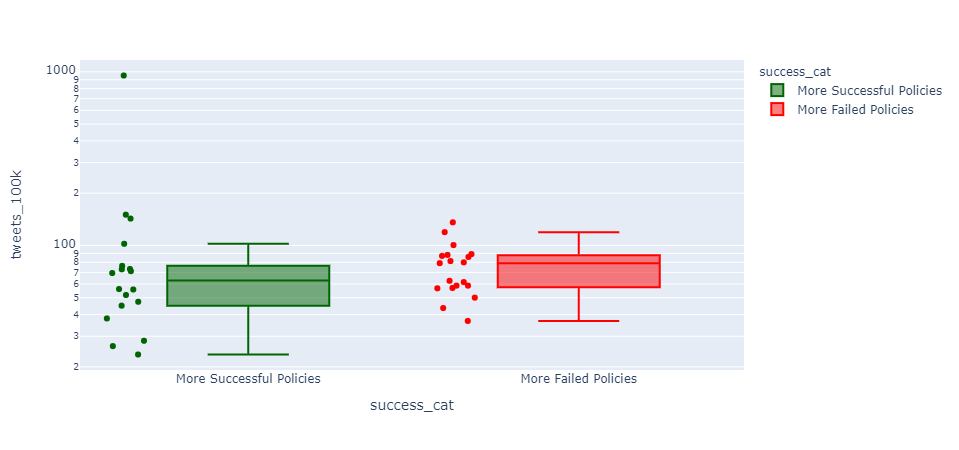

In [414]:
px.box(state_tp_stat_out[(state_tp_stat_out['success_cat']!="")], x = "success_cat", y="tweets_100k", 
       hover_data=['state', 'tweets_100k', 'policy_success_rate'], color = 'success_cat', color_discrete_sequence = ['darkgreen', 'red'],
       points = "all", log_y=True)
# fig.add_trace(px.strip(x='success_cat', y='tweets_100k'))
# fig.show()

In [415]:
# state_tp_stat_out

In [297]:
# soup = BeautifulSoup(open(fr"C:/Users/Leonardo/OneDrive/Documents/TU_Delft/CodingProjects/PoliceBrutality/data/raw/NCLS/2020_policies.html"), "html.parser")
#     # clean html and convert policies to list of strings
# policies = soup.find_all('div', id = "dnn_ctr93953_StateNetDB_linkList")[0].text.split('\n')

In [296]:
# policies_str = list(filter(None,[el.replace('  ','') for el in list(filter(None, policies))]))
# policies_str_cl = [el for el in policies_str if "Text Lookup" not in el]
# print("There were", len([policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']), "state policies related to policing in 2021.")

In [193]:
# state_abbrv = [state.abbr for state in us.STATES]

In [295]:
# len([el for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20])

In [289]:
# # extract all info of interest
# # policy_id = [el for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20]
# policy_id = [policies_str_cl[i-3] for i, x in enumerate(policies_str_cl) if x == 'Status:']
# # state = [el[:2] for x in state_abbrv for el in policies_str_cl if el.startswith(x) and len(el)<20]
# state = [el[:2] for el in policy_id]
# year = [el for el in policies_str_cl if el.startswith("2021") or el.startswith("2020")]
# status = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Status:']
# DOLA = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Date of Last Action:*\xa0']
# author = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Author:']
# topics = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Topics: ']
# summary = [policies_str_cl[i+1] for i, x in enumerate(policies_str_cl) if x == 'Summary: ']
# history = [policies_str_cl[i-4] for i, x in enumerate(policies_str_cl) if x == 'Status:']

# df_data = {"policy_id": policy_id, "state": state, "year": year, "status": status, 
#            "date_of_last_action": DOLA, "author": author, "topics": topics, "summary": summary, "history": history}

# df_policies = pd.DataFrame.from_dict(df_data)

In [290]:
# policies_str_cl[:100]

In [291]:
# [policies_str_cl[i-4] for i, x in enumerate(policies_str_cl) if x == 'Status:']